In [1]:
# Fix OpenMP conflict - set this before importing PyTorch/NumPy
# This allows parallel sampling without deadlocks
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

## Setup

In [2]:
# Add parent directory to path for imports
import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parent))

In [3]:
import numpy as np
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

print(f"PyMC version: {pm.__version__}")

PyMC version: 5.26.1


In [4]:
import importlib
import gimbal.pymc_distributions
importlib.reload(gimbal.pymc_distributions)
from gimbal.pymc_distributions import VonMisesFisher, vmf_random, vmf_logp

## 1. Test Random Sampling

Test that `vmf_random()` generates valid samples on the unit sphere.

In [5]:
# Set parameters
mu = np.array([0., 0., 1.])  # Mean direction (north pole)
kappa = 10.0  # Concentration
n_samples = 1000

# Generate samples
rng = np.random.default_rng(42)
samples = vmf_random(mu, kappa, size=(n_samples,), rng=rng)

print(f"Samples shape: {samples.shape}")
print(f"Expected: ({n_samples}, 3)")

Samples shape: (1000, 3)
Expected: (1000, 3)


In [6]:
# Check that samples are unit vectors
norms = np.linalg.norm(samples, axis=1)
print(f"Norm statistics:")
print(f"  Mean: {norms.mean():.6f}")
print(f"  Std:  {norms.std():.6f}")
print(f"  Min:  {norms.min():.6f}")
print(f"  Max:  {norms.max():.6f}")
print(f"\nAll norms ≈ 1? {np.allclose(norms, 1.0)}")

Norm statistics:
  Mean: 1.000000
  Std:  0.000000
  Min:  1.000000
  Max:  1.000000

All norms ≈ 1? True


In [7]:
# Check concentration around mu
dots = samples @ mu
print(f"\nDot product with mu (cos of angle):")
print(f"  Mean: {dots.mean():.4f}")
print(f"  Std:  {dots.std():.4f}")
print(f"  Min:  {dots.min():.4f}")
print(f"  Max:  {dots.max():.4f}")
print(f"\nMean angle from mu: {np.arccos(dots.mean()) * 180 / np.pi:.2f}°")


Dot product with mu (cos of angle):
  Mean: 0.9029
  Std:  0.1101
  Min:  0.0224
  Max:  1.0000

Mean angle from mu: 25.46°


## 2. Visualize Samples on Sphere

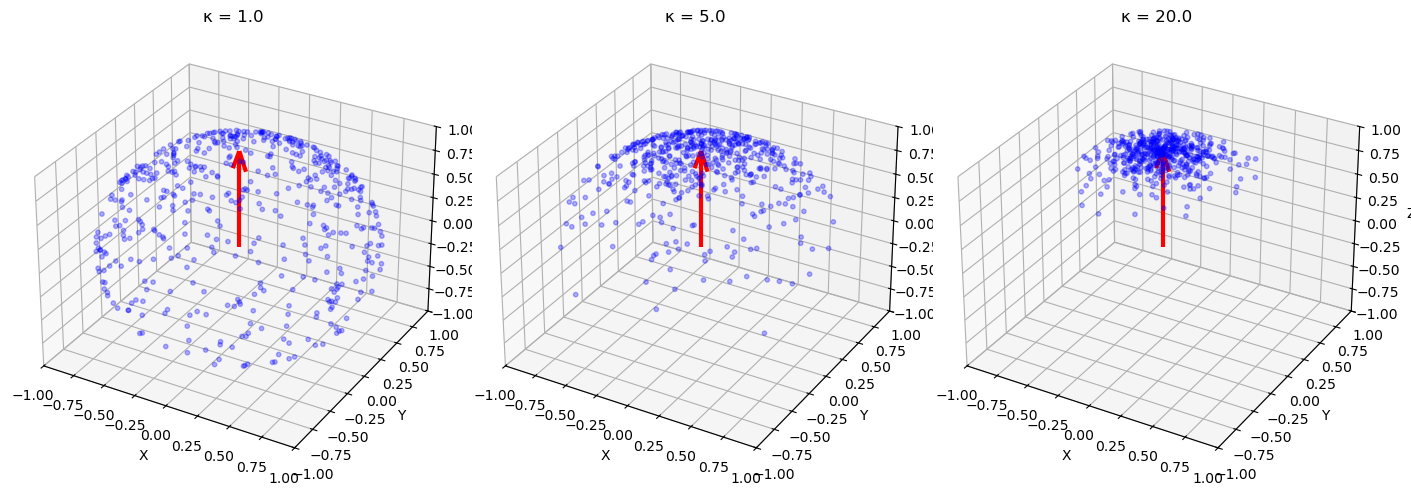

In [8]:
fig = plt.figure(figsize=(14, 5))

# Different kappa values
kappas = [1.0, 5.0, 20.0]

for i, kappa_val in enumerate(kappas):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    
    # Generate samples
    samples_k = vmf_random(mu, kappa_val, size=(500,), rng=rng)
    
    # Plot samples
    ax.scatter(samples_k[:, 0], samples_k[:, 1], samples_k[:, 2], 
               alpha=0.3, s=10, c='blue')
    
    # Plot mean direction
    ax.quiver(0, 0, 0, mu[0], mu[1], mu[2], 
              color='red', arrow_length_ratio=0.2, linewidth=3, label='μ')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'κ = {kappa_val}')
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])

plt.tight_layout()
plt.show()

## 3. Test Log-Probability Function

Verify that `vmf_logp()` works correctly in PyTensor.

In [9]:
import pytensor.tensor as pt

# Create symbolic variables
value_t = pt.matrix('value')
mu_t = pt.vector('mu')
kappa_t = pt.scalar('kappa')

# Compute log-probability
logp_t = vmf_logp(value_t, mu_t, kappa_t)

# Compile function
import pytensor
logp_fn = pytensor.function([value_t, mu_t, kappa_t], logp_t)

# Test with our samples
test_samples = samples[:10]  # Just 10 samples
logp_vals = logp_fn(test_samples, mu, kappa)

print(f"Log-probabilities for 10 samples:")
print(logp_vals)
print(f"\nAll finite? {np.all(np.isfinite(logp_vals))}")

Log-probabilities for 10 samples:
[ 0.32357334 -0.46501398 -1.35207839  0.07809614 -0.53072504  0.25581398
 -0.12716792 -0.41421649 -1.35760127 -2.63881066]

All finite? True


## 4. Test in PyMC Model (Prior Sampling)

Use the custom distribution in a PyMC model and draw prior samples.

In [10]:
with pm.Model() as model_prior:
    # Mean direction (fixed)
    mu_fixed = np.array([0., 0., 1.])
    
    # Concentration parameter
    kappa = pm.Exponential("kappa", 0.1)
    
    # vMF distribution
    u = VonMisesFisher("u", mu=mu_fixed, kappa=kappa, shape=(10, 3))
    
print("Model created successfully")
print(model_prior)

Model created successfully


In [11]:
# Draw prior samples
with model_prior:
    prior_samples = pm.sample_prior_predictive(samples=100, random_seed=42)
    
print("Prior sampling completed")
print(f"u shape: {prior_samples.prior['u'].shape}")

Sampling: [kappa, u]


Prior sampling completed
u shape: (1, 100, 10, 3)


In [12]:
# Check unit vector constraint
u_samples = prior_samples.prior['u'].values  # shape: (1, 100, 10, 3)
u_norms = np.linalg.norm(u_samples, axis=-1)

print(f"Unit vector check:")
print(f"  All norms ≈ 1? {np.allclose(u_norms, 1.0)}")
print(f"  Mean norm: {u_norms.mean():.6f}")
print(f"  Max deviation: {np.abs(u_norms - 1.0).max():.6e}")

Unit vector check:
  All norms ≈ 1? True
  Mean norm: 1.000000
  Max deviation: 2.220446e-16


## 5. Test in PyMC Model (Posterior Sampling)

Create synthetic data and perform inference to recover parameters.

In [13]:
# Generate synthetic data
true_kappa = 15.0
true_mu = np.array([0., np.sin(np.pi/6), np.cos(np.pi/6)])  # 30° from north pole
n_obs = 50

# Generate observations
rng = np.random.default_rng(123)
observed_data = vmf_random(true_mu, true_kappa, size=(n_obs,), rng=rng)

print(f"Generated {n_obs} observations")
print(f"True κ: {true_kappa}")
print(f"True μ: {true_mu}")

Generated 50 observations
True κ: 15.0
True μ: [0.        0.5       0.8660254]


In [14]:
# Build inference model
with pm.Model() as model_inference:
    # Prior on concentration
    kappa = pm.Exponential("kappa", 0.1)
    
    # Prior on mean direction (uniform on sphere)
    # We'll use a simple approach: three independent normals, then normalize
    mu_raw = pm.Normal("mu_raw", 0, 1, shape=3)
    mu = pm.Deterministic("mu", mu_raw / pt.sqrt(pt.sum(mu_raw**2)))
    
    # Likelihood
    u_obs = VonMisesFisher("u_obs", mu=mu, kappa=kappa, observed=observed_data)
    
print("Inference model created")
print(model_inference)

Inference model created


In [15]:
# Sample posterior
with model_inference:
    trace = pm.sample(1000, tune=1000, chains=2, random_seed=456, 
                      target_accept=0.9)
    
print("\nPosterior sampling completed")

c:\Repositories\GIMBAL_Python\.pixi\envs\default\Lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [kappa, mu_raw]
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [kappa, mu_raw]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 40 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics



Posterior sampling completed


In [16]:
# Summary statistics
print("\nPosterior summary:")
print(az.summary(trace, var_names=["kappa", "mu"]))


Posterior summary:
         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
kappa  12.969  1.976   9.322   16.647      0.074    0.056     701.0     678.0   
mu[0]  -0.037  0.043  -0.120    0.044      0.002    0.001     773.0     945.0   
mu[1]   0.510  0.036   0.445    0.579      0.001    0.001    2119.0    1562.0   
mu[2]   0.857  0.022   0.817    0.898      0.000    0.000    2097.0    1403.0   

       r_hat  
kappa    1.0  
mu[0]    1.0  
mu[1]    1.0  
mu[2]    1.0  


In [17]:
# Compare with true values
kappa_posterior_mean = trace.posterior["kappa"].mean().item()
mu_posterior_mean = trace.posterior["mu"].mean(dim=["chain", "draw"]).values

print(f"\nParameter Recovery:")
print(f"κ: true={true_kappa:.2f}, estimated={kappa_posterior_mean:.2f}")
print(f"\nμ comparison:")
print(f"  True:      {true_mu}")
print(f"  Estimated: {mu_posterior_mean}")
print(f"  Dot product: {np.dot(true_mu, mu_posterior_mean):.4f}")
print(f"  Angle difference: {np.arccos(np.dot(true_mu, mu_posterior_mean)) * 180 / np.pi:.2f}°")


Parameter Recovery:
κ: true=15.00, estimated=12.97

μ comparison:
  True:      [0.        0.5       0.8660254]
  Estimated: [-0.03746953  0.51048263  0.85697488]
  Dot product: 0.9974
  Angle difference: 4.13°


## 6. Diagnostic Plots

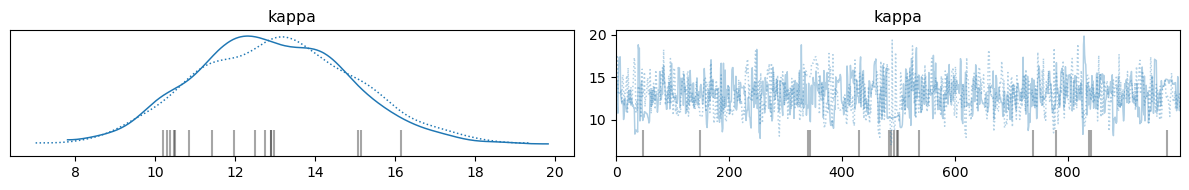

In [18]:
# Trace plot
az.plot_trace(trace, var_names=["kappa"])
plt.tight_layout()
plt.show()

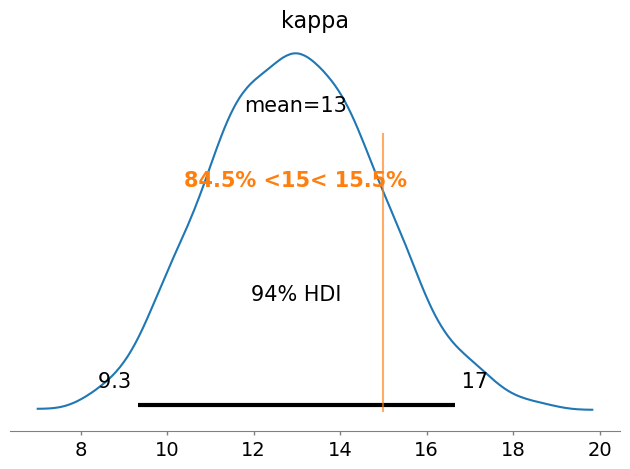

In [19]:
# Posterior plot for kappa
az.plot_posterior(trace, var_names=["kappa"], ref_val=true_kappa)
plt.tight_layout()
plt.show()

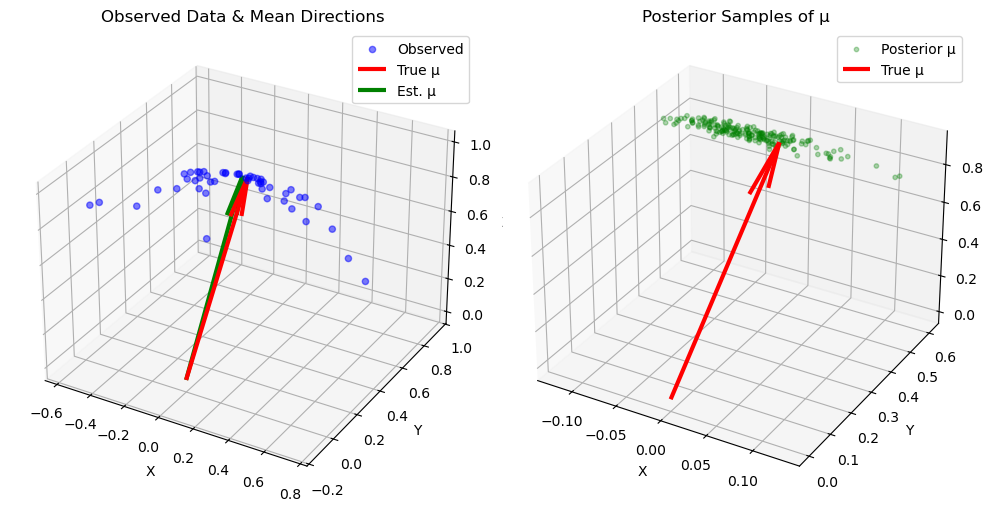

In [20]:
# Visualize estimated mean direction
fig = plt.figure(figsize=(10, 5))

# 3D plot
ax = fig.add_subplot(121, projection='3d')
ax.scatter(observed_data[:, 0], observed_data[:, 1], observed_data[:, 2],
           alpha=0.5, s=20, c='blue', label='Observed')
ax.quiver(0, 0, 0, true_mu[0], true_mu[1], true_mu[2],
          color='red', arrow_length_ratio=0.2, linewidth=3, label='True μ')
ax.quiver(0, 0, 0, mu_posterior_mean[0], mu_posterior_mean[1], mu_posterior_mean[2],
          color='green', arrow_length_ratio=0.2, linewidth=3, label='Est. μ')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Observed Data & Mean Directions')
ax.legend()

# Posterior samples of mu on sphere
ax2 = fig.add_subplot(122, projection='3d')
mu_samples = trace.posterior["mu"].values.reshape(-1, 3)[:200]  # Take 200 samples
ax2.scatter(mu_samples[:, 0], mu_samples[:, 1], mu_samples[:, 2],
            alpha=0.3, s=10, c='green', label='Posterior μ')
ax2.quiver(0, 0, 0, true_mu[0], true_mu[1], true_mu[2],
           color='red', arrow_length_ratio=0.2, linewidth=3, label='True μ')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Posterior Samples of μ')
ax2.legend()

plt.tight_layout()
plt.show()

## Summary

This notebook verified that the custom `VonMisesFisher` distribution:
- ✅ Generates valid unit vectors on S²
- ✅ Samples concentrate around the mean direction μ with concentration κ
- ✅ Log-probability function works in PyTensor
- ✅ Can be used in PyMC models for prior sampling
- ✅ Can be used in PyMC models for posterior inference
- ✅ Recovers true parameters from synthetic data

**The custom vMF distribution is ready to use in the GIMBAL PyMC implementation!**